# Magnetic Data Transformation

In this notebook you will undertake the data processing steps that are necessary in order to produce a magnetic anomaly map

In [62]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pathlib import Path
from scipy import interpolate
import pyproj
import warnings

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt


## Defining Functions (Fatiando Legacy)
We will use a few functions in order to perform typical transformation. The following cell will define necessary functions.

In [43]:
def ang2vec(intensity, inc, dec):
    """
    Convert intensity, inclination and  declination to a 3-component vector

    .. note:: Coordinate system is assumed to be x->North, y->East, z->Down.
        Inclination is positive down and declination is measured with respect
        to x (North).

    Parameter:

    * intensity : float or array
        The intensity (norm) of the vector
    * inc : float
        The inclination of the vector (in degrees)
    * dec : float
        The declination of the vector (in degrees)

    Returns:

    * vec : array = [x, y, z]
        The vector

    Examples::

        >>> import np
        >>> print ang2vec(3, 45, 45)
        [ 1.5         1.5         2.12132034]
        >>> print ang2vec(np.arange(4), 45, 45)
        [[ 0.          0.          0.        ]
         [ 0.5         0.5         0.70710678]
         [ 1.          1.          1.41421356]
         [ 1.5         1.5         2.12132034]]

    """
    return np.transpose([intensity * i for i in dircos(inc, dec)])
def dircos(inc, dec):
    """
    Returns the 3 coordinates of a unit vector given its inclination and
    declination.

    .. note:: Coordinate system is assumed to be x->North, y->East, z->Down.
        Inclination is positive down and declination is measured with respect
        to x (North).

    Parameter:

    * inc : float
        The inclination of the vector (in degrees)
    * dec : float
        The declination of the vector (in degrees)

    Returns:

    * vect : list = [x, y, z]
        The unit vector

    """
    d2r = np.pi / 180.
    vect = [np.cos(d2r * inc) * np.cos(d2r * dec),
            np.cos(d2r * inc) * np.sin(d2r * dec),
            np.sin(d2r * inc)]
    return vect
def _fftfreqs(x, y, shape, padshape):
    """
    Get two 2D-arrays with the wave numbers in the x and y directions.
    """
    nx, ny = shape
    dx = (x.max() - x.min())/(nx - 1)
    fx = 2*np.pi*np.fft.fftfreq(padshape[0], dx)
    dy = (y.max() - y.min())/(ny - 1)
    fy = 2*np.pi*np.fft.fftfreq(padshape[1], dy)
    return np.meshgrid(fy, fx)[::-1]
def reduce_to_pole(x, y, data, shape, inc, dec, sinc, sdec):
    r"""
    Reduce total field magnetic anomaly data to the pole.

    The reduction to the pole if a phase transformation that can be applied to
    total field magnetic anomaly data. It "simulates" how the data would be if
    **both** the Geomagnetic field and the magnetization of the source were
    vertical (:math:`90^\circ` inclination) (Blakely, 1996).

    This functions performs the reduction in the frequency domain (using the
    FFT). The transform filter is (in the frequency domain):

    .. math::

        RTP(k_x, k_y) = \frac{|k|}{
            a_1 k_x^2 + a_2 k_y^2 + a_3 k_x k_y +
            i|k|(b_1 k_x + b_2 k_y)}

    in which :math:`k_x` and :math:`k_y` are the wave-numbers in the x and y
    directions and

    .. math::

        |k| = \sqrt{k_x^2 + k_y^2} \\
        a_1 = m_z f_z - m_x f_x \\
        a_2 = m_z f_z - m_y f_y \\
        a_3 = -m_y f_x - m_x f_y \\
        b_1 = m_x f_z + m_z f_x \\
        b_2 = m_y f_z + m_z f_y

    :math:`\mathbf{m} = (m_x, m_y, m_z)` is the unit-vector of the total
    magnetization of the source and
    :math:`\mathbf{f} = (f_x, f_y, f_z)` is the unit-vector of the Geomagnetic
    field.

    .. note:: Requires gridded data.

    .. warning::

        The magnetization direction of the anomaly source is crucial to the
        reduction-to-the-pole.
        **Wrong values of *sinc* and *sdec* will lead to a wrong reduction.**

    Parameters:

    * x, y : 1d-arrays
        The x, y, z coordinates of each data point.
    * data : 1d-array
        The total field anomaly data at each point.
    * shape : tuple = (nx, ny)
        The shape of the data grid
    * inc, dec : floats
        The inclination and declination of the inducing Geomagnetic field
    * sinc, sdec : floats
        The inclination and declination of the total magnetization of the
        anomaly source. The total magnetization is the vector sum of the
        induced and remanent magnetization. If there is only induced
        magnetization, use the *inc* and *dec* of the Geomagnetic field.

    Returns:

    * rtp : 1d-array
        The data reduced to the pole.

    References:

    Blakely, R. J. (1996), Potential Theory in Gravity and Magnetic
    Applications, Cambridge University Press.

    """
    fx, fy, fz = ang2vec(1, inc, dec)
    if sinc is None or sdec is None:
        mx, my, mz = fx, fy, fz
    else:
        mx, my, mz = ang2vec(1, sinc, sdec)
    kx, ky = [k for k in _fftfreqs(x, y, shape, shape)]
    kz_sqr = kx**2 + ky**2
    a1 = mz*fz - mx*fx
    a2 = mz*fz - my*fy
    a3 = -my*fx - mx*fy
    b1 = mx*fz + mz*fx
    b2 = my*fz + mz*fy
    # The division gives a RuntimeWarning because of the zero frequency term.
    # This suppresses the warning.
    with np.errstate(divide='ignore', invalid='ignore'):
        rtp = (kz_sqr)/(a1*kx**2 + a2*ky**2 + a3*kx*ky +
                        1j*np.sqrt(kz_sqr)*(b1*kx + b2*ky))
    rtp[0, 0] = 0
    ft_pole = rtp*np.fft.fft2(np.reshape(data, shape))
    return np.real(np.fft.ifft2(ft_pole)).ravel()
def upcontinue(x, y, data, shape, height):
    r"""
    Upward continuation of potential field data.

    Calculates the continuation through the Fast Fourier Transform in the
    wavenumber domain (Blakely, 1996):

    .. math::

        F\{h_{up}\} = F\{h\} e^{-\Delta z |k|}

    and then transformed back to the space domain. :math:`h_{up}` is the upward
    continue data, :math:`\Delta z` is the height increase, :math:`F` denotes
    the Fourier Transform,  and :math:`|k|` is the wavenumber modulus.

    .. note:: Requires gridded data.

    .. note:: x, y, z and height should be in meters.

    .. note::

        It is not possible to get the FFT of a masked grid. The default
        :func:`fatiando.gridder.interp` call using minimum curvature will not
        be suitable.  Use ``extrapolate=True`` or ``algorithm='nearest'`` to
        get an unmasked grid.

    Parameters:

    * x, y : 1D-arrays
        The x and y coordinates of the grid points
    * data : 1D-array
        The potential field at the grid points
    * shape : tuple = (nx, ny)
        The shape of the grid
    * height : float
        The height increase (delta z) in meters.

    Returns:

    * cont : array
        The upward continued data

    References:

    Blakely, R. J. (1996), Potential Theory in Gravity and Magnetic
    Applications, Cambridge University Press.

    """
    assert x.shape == y.shape, \
        "x and y arrays must have same shape"
    if height <= 0:
        warnings.warn("Using 'height' <= 0 means downward continuation, " +
                      "which is known to be unstable.")
    nx, ny = shape
    # Pad the array with the edge values to avoid instability
    padded, padx, pady = _pad_data(data, shape)
    kx, ky = _fftfreqs(x, y, shape, padded.shape)
    kz = np.sqrt(kx**2 + ky**2)
    upcont_ft = np.fft.fft2(padded)*np.exp(-height*kz)
    cont = np.real(np.fft.ifft2(upcont_ft))
    # Remove padding
    cont = cont[padx: padx + nx, pady: pady + ny].ravel()
    return cont
def _pad_data(data, shape):
    n = _nextpow2(np.max(shape))
    nx, ny = shape
    padx = (n - nx)//2
    pady = (n - ny)//2
    padded = np.pad(data.reshape(shape), ((padx, padx), (pady, pady)),
                        mode='edge')
    return padded, padx, pady
def _nextpow2(i):
    buf = np.ceil(np.log(i)/np.log(2))
    return int(2**buf)

## Importing & Combining 
After every student processed their recorded data, it is time to combine all data for further processing

In [53]:
dr =Path(r'C:\Users\julik\sciebo\Master\Geophyphox\Student Data\Processed')
preamble = 'results_magnetic_' # The filename beginning common to all magnetic data files
preambleBASE = 'results_magneticBASE_' # Filename beginning for all base station data

alldata = [] # Empty list for storing all dataframes
basedata = [] # Empty list for storing all base station dataframes

for file in os.scandir(dr):
    if file.is_file and file.name.endswith('.csv') and file.name.startswith(preamble): # Check if this is a data file
        alldata.append(pd.read_csv(file))
    elif file.is_file and file.name.endswith('.csv') and file.name.startswith(preambleBASE): # Check if this is a data file
        basedata.append(pd.read_csv(file))
        
data_combined = pd.concat(alldata, ignore_index=True)
base_combined = pd.concat(basedata, ignore_index=True)
data_combined["name"].unique()
data_combined.to_csv(r"C:/Users/julik/sciebo/Master/Data/Excursion 2021/Raw/Dürwiss/Dürwiss_combined.csv")
data_combined.head()

,Unnamed: 0,station,lat,lon,altitude,mag_x_,mag_y,mag_z,field,mag_abs_std,time,unix_time,mag_count,student_id,x,y,times,anomaly,name
0,0,0.0,50.775403,6.098364,172.374120,20.742365,-0.249843,-42.323126,47134.77842,0.284164,65.455,1.656242e+09,51.0,0.0,295429.446103,5.628864e+06,47208.0,0.000000,Random
1,1,1.0,50.775356,6.098122,168.160320,18.264511,3.784182,-42.655628,46563.46247,0.356672,119.696,1.656242e+09,49.0,0.0,295412.176139,5.628859e+06,47263.0,-503.151583,Random
2,2,2.0,50.775352,6.098110,167.967401,14.411419,1.401474,-43.778314,46114.10837,0.292772,156.980,1.656242e+09,51.0,0.0,295411.316247,5.628859e+06,47300.0,-906.649655,Random
3,3,3.0,50.775364,6.098191,170.328191,19.847165,-0.273140,-42.888051,47260.79383,0.259998,197.081,1.656242e+09,52.0,0.0,295417.075720,5.628860e+06,47340.0,289.609890,Random
4,4,4.0,50.775366,6.098193,170.306475,19.722002,0.265950,-43.832667,48067.56652,0.310212,223.549,1.656242e+09,51.0,0.0,295417.185221,5.628860e+06,47366.0,1128.605735,Random


## Spatial anomaly plot

Once we calculated our anomalies we can display them as a spatial map.

The basic way to do this is a scatterplot with color-coded markers.

In [45]:
# Defining a grid of points for which we want to interpolate
# Defining resolution (number of gridpoints) in x- and y- direction
xRes = 100
yRes = xRes

xAxis = np.linspace(data_combined['x'].min(), data_combined['x'].max(), xRes)
yAxis = np.linspace(data_combined['y'].min(), data_combined['y'].max(), yRes)

vmin = -np.max(np.abs(data_combined['anomaly']))
vmax = np.max(np.abs(data_combined['anomaly']))

# Numpy offers the meshgrid function which simplifies some input operations
mgX, mgY = np.meshgrid(xAxis, yAxis)

We can also produce a more sophisticated, continous map of our data using interpolation. Several common interpolation algorithms exist, such as polynomial interp., spline interp., and kriging.

A very straight-forward interpolation method is Nearest Neighbors, which simply assigns the unsampled point of interest the value of the sampled point that lies closest.

In [46]:
# Performing interpolation for all gridpoints
nearest_neighbors = interpolate.griddata(list(zip(data_combined['x'], data_combined['y'])), data_combined['anomaly'],
                                         list(zip(mgX.flat, mgY.flat)), method='nearest')
# Spline interpolation

linear_spline = interpolate.griddata(list(zip(data_combined['x'], data_combined['y'])), data_combined['anomaly'],
                                     list(zip(mgX.flat, mgY.flat)), method='linear',fill_value=0)


C:\Users\julik\AppData\Local\Temp/ipykernel_2148/3045307616.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


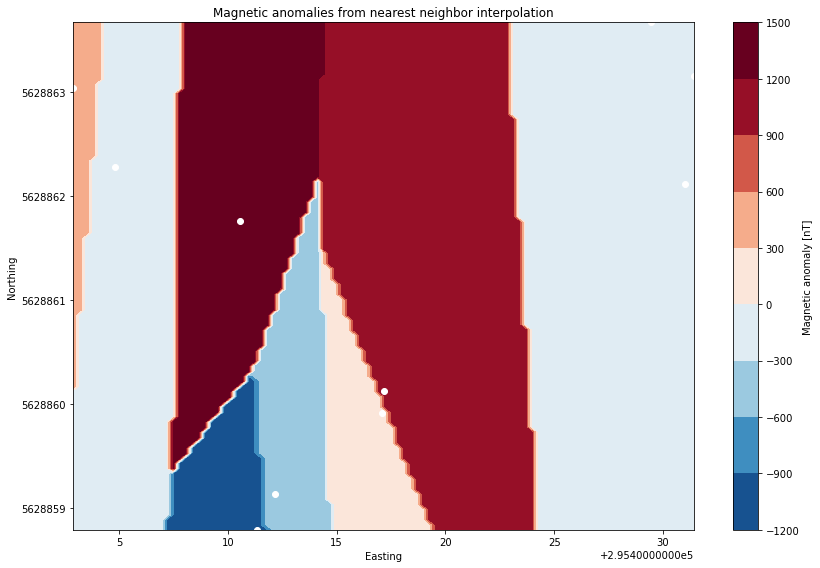

In [47]:
# plotting as a smooth contour map
fig, ax = plt.subplots(figsize=(12, 8))

im  =ax.contourf(mgX, mgY, nearest_neighbors.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="white")
ax.set(xlabel='Easting', ylabel='Northing', title='Magnetic anomalies from nearest neighbor interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()

C:\Users\julik\AppData\Local\Temp/ipykernel_2148/1324048829.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


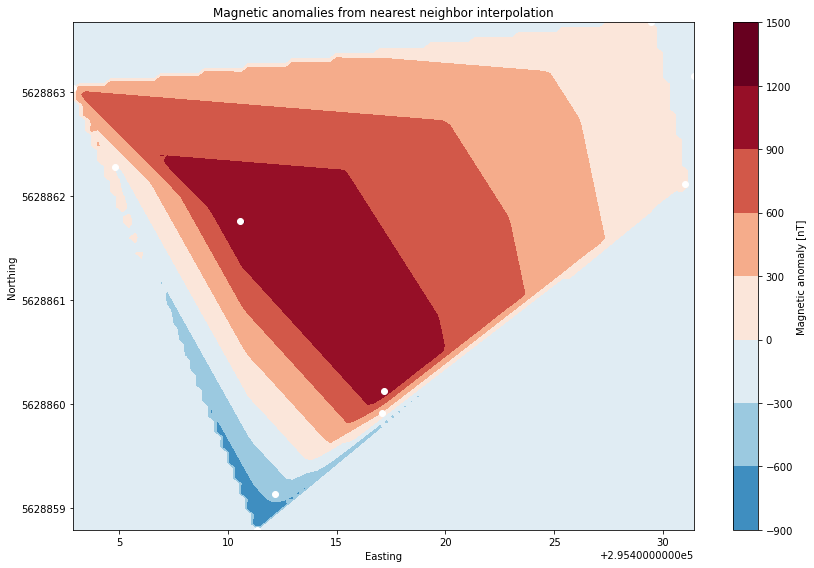

In [68]:
# plotting as a smooth contour map
fig, ax = plt.subplots(figsize=(12, 8))

im  =ax.contourf(mgX, mgY, linear_spline.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="white")
ax.set(xlabel='Easting', ylabel='Northing', title='Magnetic anomalies from nearest neighbor interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()

## Map Visualization
Using the python package [cartopy](https://scitools.org.uk/cartopy/docs/latest/) we can visualize our measurement locations maps from OpenStreetMap.


In [69]:
projection = pyproj.Proj(proj='utm',zone=32, lat_ts=data_combined['lat'].mean()) #'merc',proj='utm',zone=32,ellps='WGS84'
# Project the dataset coordinates:
easting, northing = projection(mgX, mgY,inverse=True)


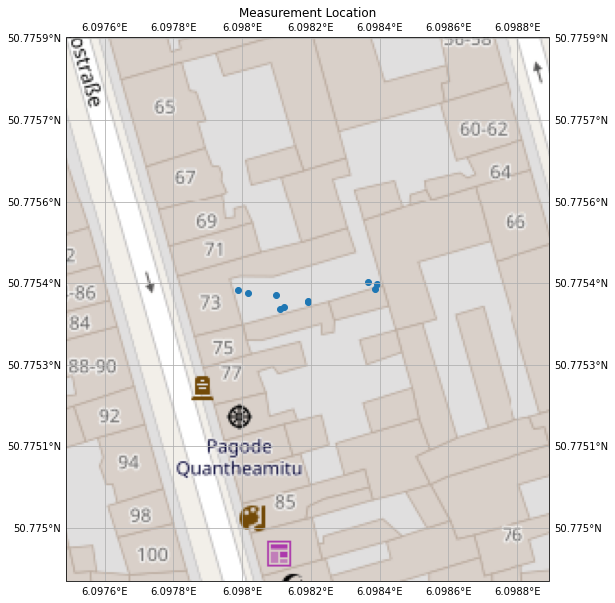

In [70]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

request = cimgt.OSM()
border = 0.0005

# Bounds: (lon_min, lon_max, lat_min, lat_max):
extent = [data_combined["lon"].min()-border,data_combined["lon"].max()+border,data_combined["lat"].min()-border,data_combined["lat"].min()+border]
# fig,ax = pl.subplots(figsize=(10,10))
plt.figure(figsize=(10,10))
ax = plt.axes(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request,18 )    # 5 = zoom level

ax.scatter(data_combined["lon"], data_combined["lat"] ,transform=ccrs.PlateCarree())
ax.set(title="Measurement Location");
ax.gridlines(draw_labels=True)

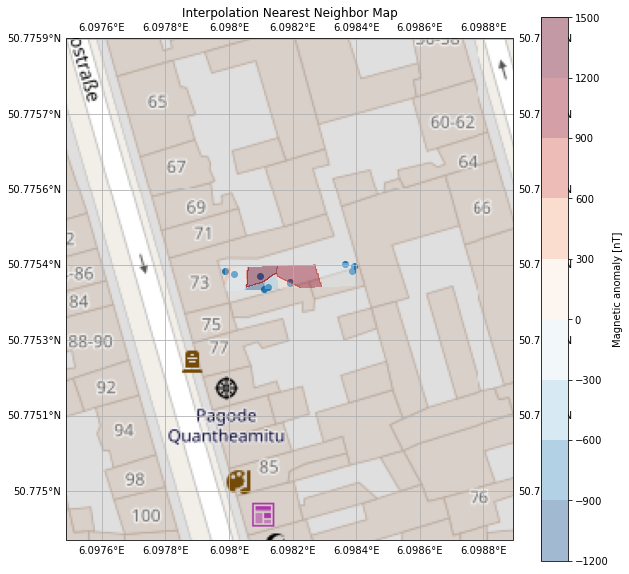

In [67]:
request = cimgt.OSM()
border = 0.0005

# Bounds: (lon_min, lon_max, lat_min, lat_max):
extent = [data_combined["lon"].min()-border,data_combined["lon"].max()+border,data_combined["lat"].min()-border,data_combined["lat"].min()+border]
plt.figure(figsize=(10,10))
ax = plt.axes(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request,18 )    # 18 = zoom level

ax.scatter(data_combined["lon"], data_combined["lat"] ,transform=ccrs.PlateCarree())
im = ax.contourf(easting, northing, nearest_neighbors.reshape(mgX.shape),transform=ccrs.PlateCarree(),
                 vmin=vmin, vmax=vmax, cmap="RdBu_r",alpha=0.4)
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')

ax.set(title="Interpolation Nearest Neighbor Map");
ax.gridlines(draw_labels=True)

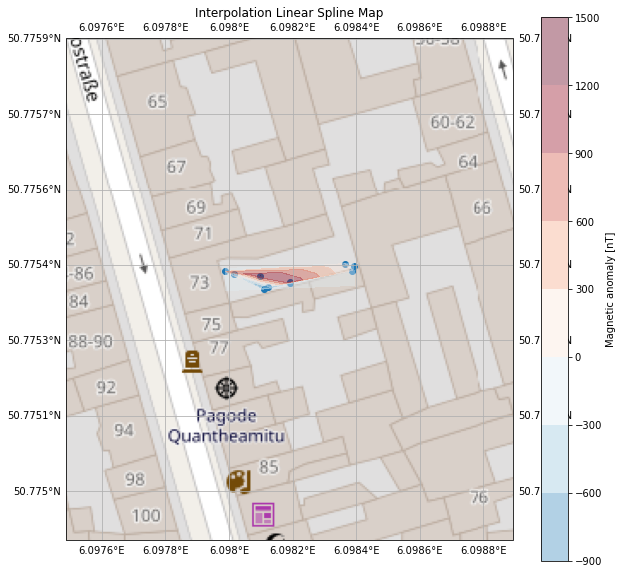

In [66]:
request = cimgt.OSM()
border = 0.0005

# Bounds: (lon_min, lon_max, lat_min, lat_max):
extent = [data_combined["lon"].min()-border,data_combined["lon"].max()+border,data_combined["lat"].min()-border,data_combined["lat"].min()+border]
plt.figure(figsize=(10,10))
ax = plt.axes(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request,18 )    # 18 = zoom level

ax.scatter(data_combined["lon"], data_combined["lat"] ,transform=ccrs.PlateCarree())
im = ax.contourf(easting, northing, linear_spline.reshape(mgX.shape),transform=ccrs.PlateCarree(),
                 vmin=vmin, vmax=vmax, cmap="RdBu_r",alpha=0.4)
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')

ax.set(title="Interpolation Linear Spline Map");
ax.gridlines(draw_labels=True)

## Reduction to pole (RTP)
RTP is a method which removes the dependence of magnetic data on magnetic inclination. Magnetic data is transformed to a field which would have been measured   
at the poles, where the field is vertical. That way anomaly asymemmetry is removed. ([SEG-Wiki](https://wiki.seg.org/wiki/Dictionary:Reduction_to_the_pole_(RTP)))

This functions performs the reduction in the frequency domain (using the
FFT). The transform filter is (in the frequency domain):



### Synthetic Example
A synthetic magnetized prism located in a certain depth is used to showcase how reduction to pole can improve anomaly visibility. The prism is 
Created with Fatiando Legacy 

Text(0.5, 1.0, 'Reduced to the pole FFT algorithm')

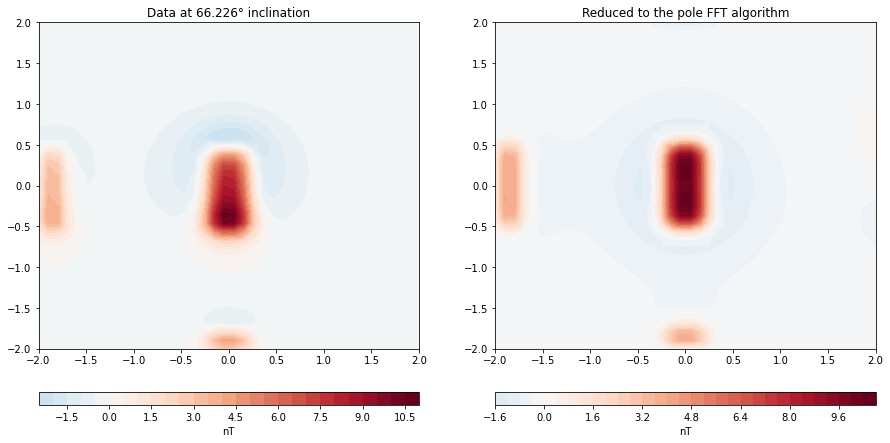

In [71]:
df = pd.read_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Synthetic Data\synthetic_RTP.csv")
inc, dec = 66.226, 2.16
df["rtp_fft"] = reduce_to_pole(x=df["x"].values,y=df["y"].values,data=df["data"].values,shape=(40,40),inc=inc,dec= dec,sinc=inc, sdec=dec)
amp = np.abs([df["data"].min(),df["data"].max()]).max()
fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]

tmp =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["data"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Data at {}° inclination'.format(inc))

ax = axes[1]
amp = np.abs([df["rtp_fft"].min(),df["rtp_fft"].max()]).max()

tmp =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["rtp_fft"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Reduced to the pole FFT algorithm')



Now using real data, from our excursion

Text(0.5, 1.0, 'Reduced to the pole FFT algorithm')

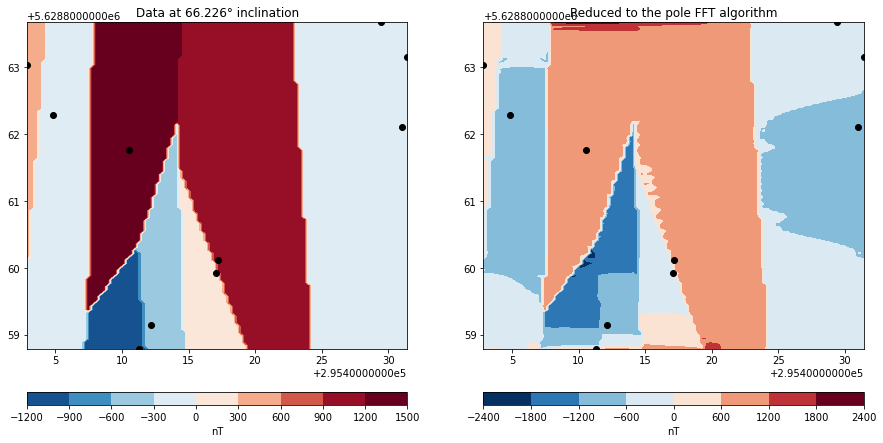

In [72]:
inc, dec = 66.226, 2.16
rtp_nearest = reduce_to_pole(mgX.flatten() , mgY.flatten(), nearest_neighbors, shape=(xRes,yRes),
                inc=inc,dec= dec,sinc=inc, sdec=dec)

fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]
amp = np.abs([nearest_neighbors.min(),nearest_neighbors.max()]).max()


tmp =ax.contourf(mgX, mgY, nearest_neighbors.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Data at {}° inclination'.format(inc))

ax = axes[1]
amp = np.abs([rtp_nearest.min(),rtp_nearest.max()]).max()

tmp =ax.contourf(mgX, mgY, rtp_nearest.reshape(mgX.shape),
            vmin=-amp, vmax=amp, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Reduced to the pole FFT algorithm')



Text(0.5, 1.0, 'Reduced to the pole FFT algorithm')

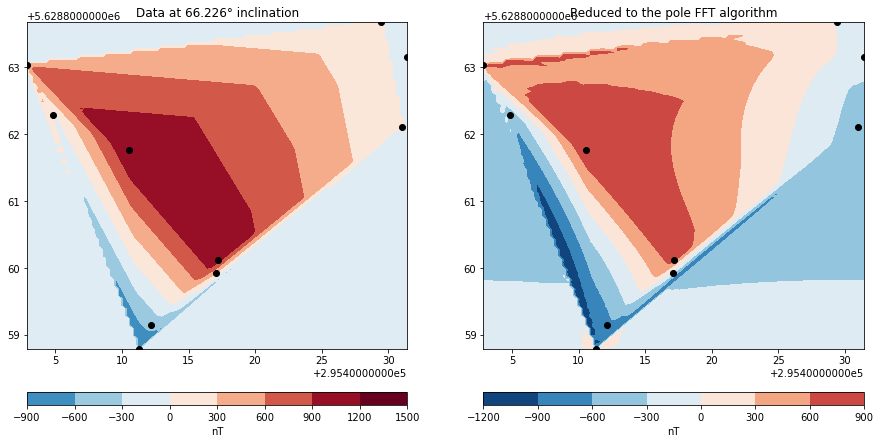

In [73]:
inc, dec = 66.226, 2.16
rtp_spline = reduce_to_pole(mgX.flatten() , mgY.flatten(), linear_spline, shape=(xRes,yRes),
                inc=inc,dec= dec,sinc=inc, sdec=dec)

fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]
amp = np.abs([linear_spline.min(),linear_spline.max()]).max()

tmp =ax.contourf(mgX, mgY, linear_spline.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Data at {}° inclination'.format(inc))

ax = axes[1]
amp = np.abs([rtp_spline.min(),rtp_spline.max()]).max()


tmp =ax.contourf(mgX, mgY, rtp_spline.reshape(mgX.shape),
            vmin=-amp, vmax=amp, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Reduced to the pole FFT algorithm')



## Upward Continuation

### Synthetic Example
Multiple shallow buried and one deep prism anomaly

Text(0.5, 1.0, 'Upcontinued to 1000 m')

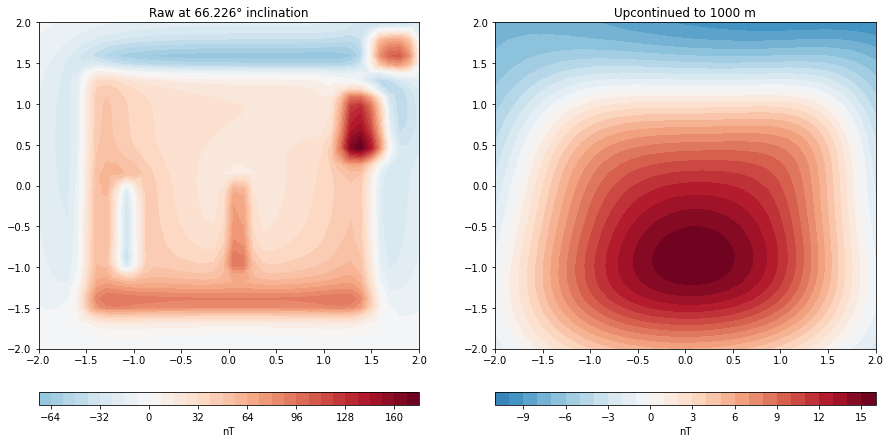

In [74]:
df = pd.read_csv(r"C:\Users\julik\sciebo\Master\Geophyphox\Synthetic Data\synthetic_upward.csv")
inc, dec = 66.226, 2.16
height = 1000

df["upcontinue"] = upcontinue(x=df.x.values,y=df.y.values,data=df.data.values,shape=(40,40),height=height)

amp = np.abs([df["data"].min(),df["data"].max()]).max()
fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]

tmp =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["data"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Raw at {}° inclination'.format(inc))

ax = axes[1]
amp = np.abs([df["upcontinue"].min(),df["upcontinue"].max()]).max()

tmp =ax.tricontourf(df["y"]/1000,df["x"]/1000,df["upcontinue"],30, cmap='RdBu_r',vmin=-amp,
                     vmax=amp)
fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Upcontinued to '+'{0} m'.format(height))


Now using real data, from our excursion

Text(0.5, 0.98, 'Nearest Neighbor')

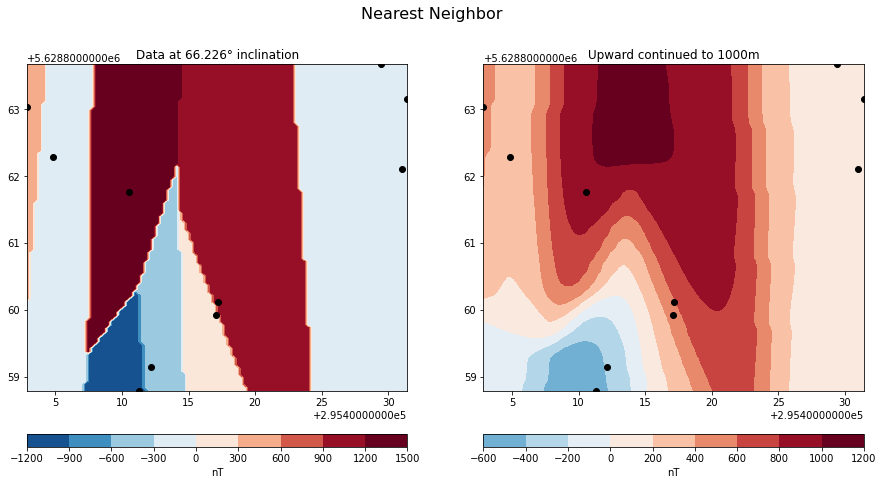

In [75]:
upward_nearest = upcontinue(mgX.flatten() , mgY.flatten(), nearest_neighbors, shape=(xRes,yRes),
                height=0.3)

fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]
amp = np.abs([nearest_neighbors.min(),nearest_neighbors.max()]).max()

tmp =ax.contourf(mgX, mgY, nearest_neighbors.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Data at {}° inclination'.format(inc))

ax = axes[1]
amp = np.abs([upward_nearest.min(),upward_nearest.max()]).max()


tmp =ax.contourf(mgX, mgY, upward_nearest.reshape(mgX.shape),
            vmin=-amp, vmax=amp, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Upward continued to {}m'.format(height))
fig.suptitle('Nearest Neighbor', fontsize=16)



Text(0.5, 0.98, 'Linear Spline')

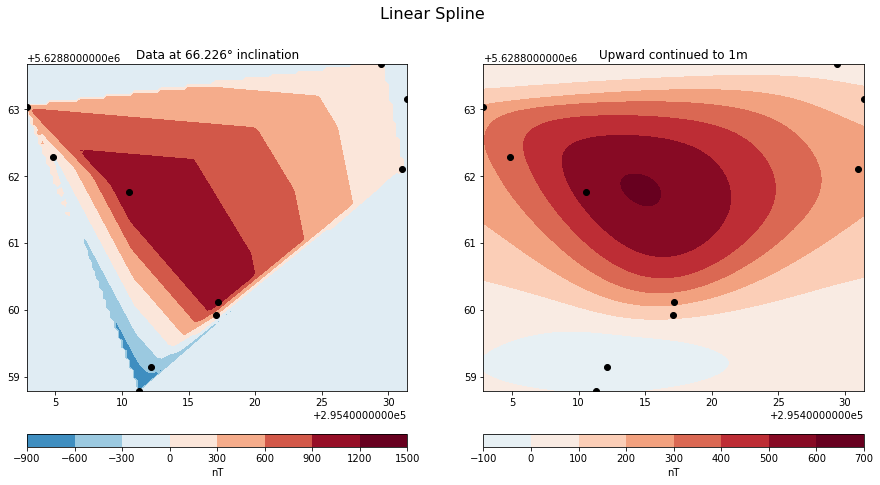

In [76]:
height = 1
upward_spline = upcontinue(mgX.flatten() , mgY.flatten(), linear_spline, shape=(xRes,yRes),
                height=height)

fig,axes  = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]
amp = np.abs([linear_spline.min(),linear_spline.max()]).max()

tmp =ax.contourf(mgX, mgY, linear_spline.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title(u'Data at {}° inclination'.format(inc))

ax = axes[1]
amp = np.abs([upward_spline.min(),upward_spline.max()]).max()


tmp =ax.contourf(mgX, mgY, upward_spline.reshape(mgX.shape),
            vmin=-amp, vmax=amp, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="black")

fig.colorbar(tmp, ax=ax, pad=0.1, aspect=30,
             orientation='horizontal').set_label('nT')
ax.set_title('Upward continued to {}m'.format(height))
fig.suptitle('Linear Spline', fontsize=16)


## Extracting profile line
Clicking on the plot will save the coordinates.  
The cell below the plot will show the clicked positions


C:\Users\julik\AppData\Local\Temp/ipykernel_2148/1510924188.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


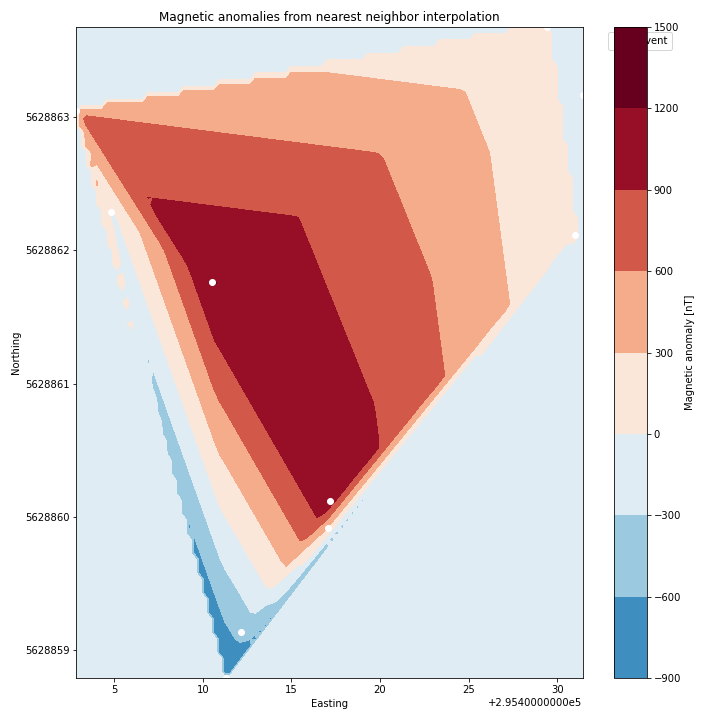

In [91]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_point_clicker import clicker

fig, ax = plt.subplots(figsize=(10,10))
im  =ax.contourf(mgX, mgY, linear_spline.reshape(mgX.shape),
            vmin=vmin, vmax=vmax, cmap="RdBu_r")
ax.scatter(data_combined['x'], data_combined['y'],color="white")
ax.set(xlabel='Easting', ylabel='Northing', title='Magnetic anomalies from nearest neighbor interpolation')
ax.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
plt.colorbar(im, ax=ax, label='Magnetic anomaly [nT]')
plt.tight_layout()
klicker = clicker(ax, ["event"], markers=["x"])
plt.show()


In [92]:
#Print profile start and end
print(klicker.get_positions())


{'event': array([[ 295429.48503746, 5628863.63410736],
       [ 295409.78464764, 5628861.67054225]])}


In [93]:
%matplotlib inline
from matplotlib.patches import Polygon

# Enter Starting point coordinates here
profileStartX,profileStartY =   295429.48503746, 5628863.63410736


# Enter coordinates of profile endpoint here
profileEndX,profileEndY  = 295409.78464764, 5628861.67054225
tol = 0.5

# Create a slim polygon that represents the profile line
selection = Polygon([[profileStartX-tol/2, profileStartY-tol/2], [profileEndX-tol/2, profileEndY-tol/2],
                    [profileEndX+tol/2, profileEndY+tol/2], [profileStartX+tol/2, profileStartY+tol/2]])

# Selecting datapoints that lie along the profile
selectMask = selection.contains_points(list(zip(data_combined['x'], data_combined['y'])))
profileX = data_combined['x'][selectMask]
profileY = data_combined['y'][selectMask]
profileAnomaly = np.array(data_combined['anomaly'][selectMask])

# Selecting points from the interpolation grid 
selectMaskInterp = selection.contains_points(list(zip(mgX.flat, mgY.flat)))
profileXInterp = mgX.flat[selectMaskInterp]
profileYInterp = mgY.flat[selectMaskInterp]
profileAnomalyInterp = np.array(linear_spline.flat[selectMaskInterp]) # Change linear_spline to desired interpolation

# # Computing distances along the profile
distances = []
for _x, _y in zip(profileX, profileY):
    distances.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
distances = np.array(distances)
distances_sorted = distances[distances.argsort()]
anomalies_sorted = profileAnomaly[distances.argsort()]

# # Computing distances for interpolated data
distancesInterp = []
for _x, _y in zip(profileXInterp, profileYInterp):
    distancesInterp.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
distancesInterp = np.array(distancesInterp)
distances_sortedInterp = distancesInterp[distancesInterp.argsort()]
anomalies_sortedInterp = profileAnomalyInterp[distancesInterp.argsort()]

C:\Users\julik\AppData\Local\Temp/ipykernel_2148/299043855.py:31: RuntimeWarning: invalid value encountered in sqrt
  distances.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))
C:\Users\julik\AppData\Local\Temp/ipykernel_2148/299043855.py:39: RuntimeWarning: invalid value encountered in sqrt
  distancesInterp.append(np.sqrt((profileStartX-_x)**2+(profileStartY-_y)))


C:\Users\julik\AppData\Local\Temp/ipykernel_2148/3509200820.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels


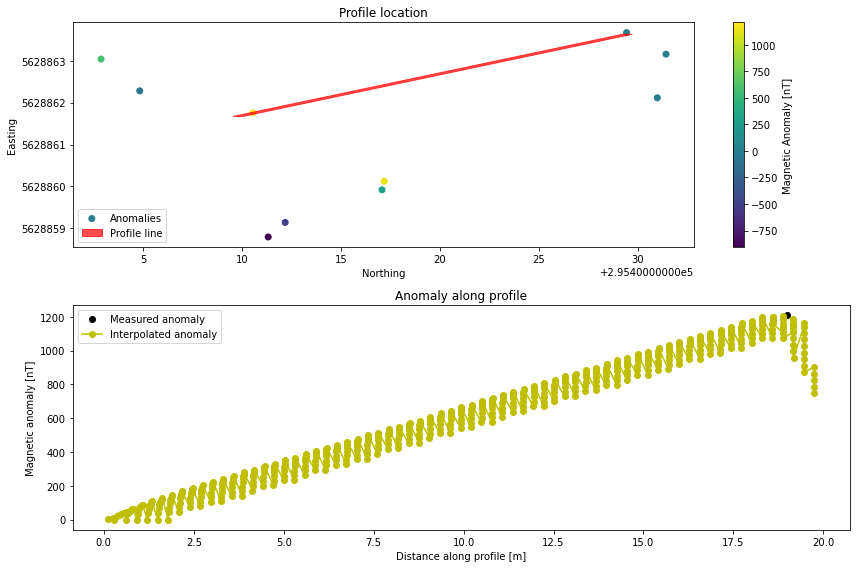

In [94]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 8))

selection_plot = Polygon([[profileStartX-tol/2, profileStartY], [profileEndX-tol/2, profileEndY],
                         [profileEndX+tol/2, profileEndY], [profileStartX+tol/2, profileStartY]],
                         label='Profile line', color='r', alpha=.7)

ax0.add_patch(selection_plot)
im0 = ax0.scatter(data_combined['x'], data_combined['y'], c=data_combined['anomaly'], label='Anomalies')
im1 = ax1.plot(distances, profileAnomaly, 'ok', label='Measured anomaly')
im2 = ax1.plot(distances_sortedInterp, anomalies_sortedInterp, '-oy', label='Interpolated anomaly')

ax0.set_yticklabels(['{:}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Fixes y-axis tick labels
ax0.legend(handles=[im0, selection_plot])
ax1.legend()

ax0.set(xlabel='Northing', ylabel='Easting', title='Profile location')
ax1.set(xlabel='Distance along profile [m]', ylabel='Magnetic anomaly [nT]', title='Anomaly along profile')
plt.colorbar(im0, ax=ax0, label='Magnetic Anomaly [nT]');

plt.tight_layout()

Saving profile data

In [95]:
# Give your profile a meaningful name and choose a folder (default is this notebooks' folder)
# The following code will save the measured profile data and teh interpolated profiledata into 2 different .csv files
profilefolder = Path(r'C:\Users\julik\sciebo\Master\Geophyphox\Student Data\Profiles')
profilename = 'profile'

profiledata_measured = pd.DataFrame({'Measured distance':distances_sorted,
                                     'Measured anomaly':anomalies_sorted})
profiledata_interpolated = pd.DataFrame({'Measured distance':distances_sortedInterp,
                                     'Measured anomaly':anomalies_sortedInterp})

profiledata_measured.to_csv(profilefolder / (profilename+'_measured.csv'))
profiledata_interpolated.to_csv(profilefolder / (profilename+'_interpolated.csv'))